# Бибилиотеки

импортируем бибилиотеки которые могут понадобится 

In [268]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Добавление и проверка данных

запихиваем данные в переменную в train данные для теренеровки в test данные для теста которые нам выдали

In [269]:
df = pd.read_excel("train.xlsx")


проверяем или мы все сделали верно и проверяем их наличие


данные есть они вывелись 

In [270]:
df["dt"] = pd.to_datetime(df["dt"])
df.set_index("dt", inplace=True)

In [271]:
scaler = MinMaxScaler()
df["Цена_норм"] = scaler.fit_transform(df[["Цена на арматуру"]])

In [272]:
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [273]:
train["time_index"] = np.arange(len(train))
test["time_index"] = np.arange(len(train), len(train) + len(test))

C:\Users\josha\AppData\Local\Temp\ipykernel_23520\1471525807.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["time_index"] = np.arange(len(train))
C:\Users\josha\AppData\Local\Temp\ipykernel_23520\1471525807.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["time_index"] = np.arange(len(train), len(train) + len(test))


In [274]:
lr = LinearRegression()
lr.fit(train[["time_index"]], train["Цена на арматуру"])
test["lr_pred"] = lr.predict(test[["time_index"]])
r2_lr = r2_score(test["Цена на арматуру"], test["lr_pred"])

C:\Users\josha\AppData\Local\Temp\ipykernel_23520\3812059360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["lr_pred"] = lr.predict(test[["time_index"]])


In [275]:
arima_model = ARIMA(train["Цена на арматуру"], order=(5,1,5))
arima_fitted = arima_model.fit()
test["arima_pred"] = arima_fitted.forecast(steps=len(test))
r2_arima = r2_score(test["Цена на арматуру"], test["arima_pred"])


c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users

In [276]:
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 10
X_train, y_train = create_sequences(train["Цена_норм"].values, seq_length)
X_test, y_test = create_sequences(test["Цена_норм"].values, seq_length)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [277]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

lstm_pred = model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
r2_lstm = r2_score(y_test_actual, lstm_pred)


c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


In [278]:
print(f"R2 Линейная регрессия: {r2_lr:.2f}")
print(f"R2 ARIMA: {r2_arima:.2f}")
print(f"R2 LSTM: {r2_lstm:.2f}")

R2 Линейная регрессия: -2.74
R2 ARIMA: -1.76
R2 LSTM: 0.88


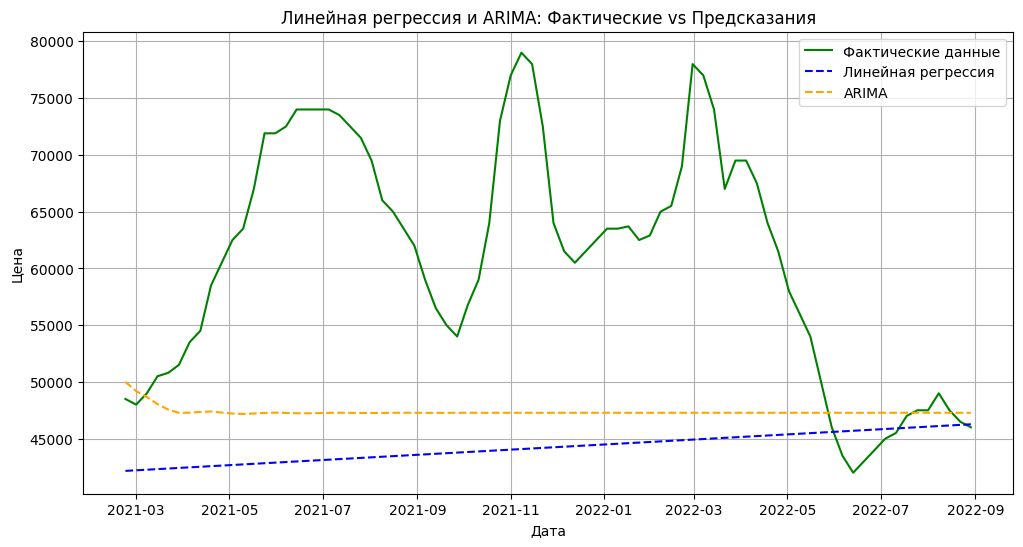

In [279]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test["Цена на арматуру"], label="Фактические данные", color="green")
plt.plot(test.index, test["lr_pred"], label="Линейная регрессия", color="blue", linestyle="dashed")
plt.plot(test.index, test["arima_pred"], label="ARIMA", color="orange", linestyle="dashed")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Линейная регрессия и ARIMA: Фактические vs Предсказания")
plt.legend()
plt.grid()
plt.show()

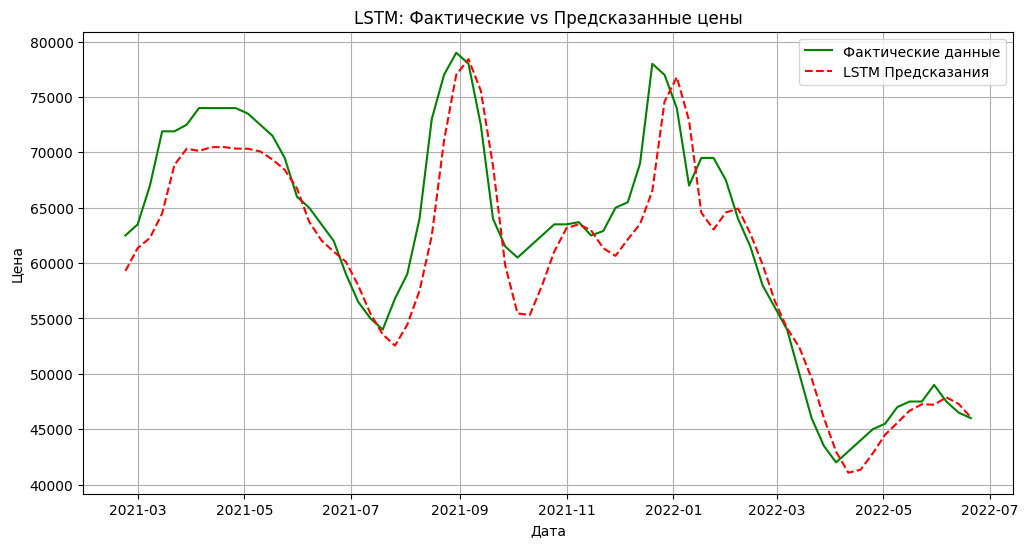

In [280]:
plt.figure(figsize=(12, 6))
plt.plot(test.index[:len(y_test_actual)], y_test_actual, label="Фактические данные", color="green")
plt.plot(test.index[:len(y_test_actual)], lstm_pred, label="LSTM Предсказания", color="red", linestyle="dashed")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("LSTM: Фактические vs Предсказанные цены")
plt.legend()
plt.grid()
plt.show()


In [281]:
r2_lstm = r2_score(y_test_actual, lstm_pred)
print(f"R2 LSTM: {r2_lstm:.2f}")


R2 LSTM: 0.88


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


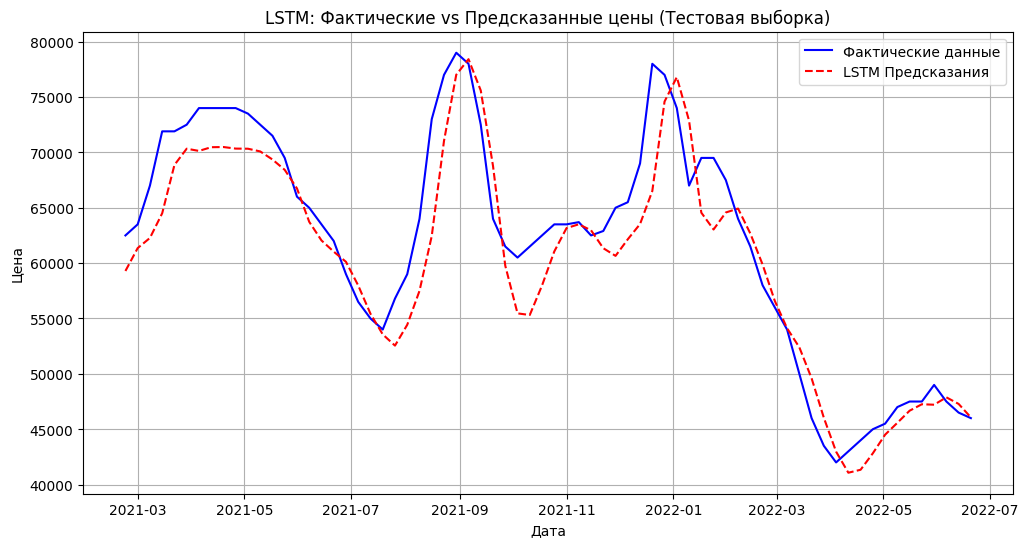

In [282]:
full_pred = model.predict(np.concatenate((X_train, X_test)))
full_pred = scaler.inverse_transform(full_pred).flatten()

plt.figure(figsize=(12, 6))
plt.plot(test.index[:len(y_test_actual)], y_test_actual, label="Фактические данные", color="blue")
plt.plot(test.index[:len(y_test_actual)], lstm_pred, label="LSTM Предсказания", color="red", linestyle="dashed")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("LSTM: Фактические vs Предсказанные цены (Тестовая выборка)")
plt.legend()
plt.grid()
plt.show()


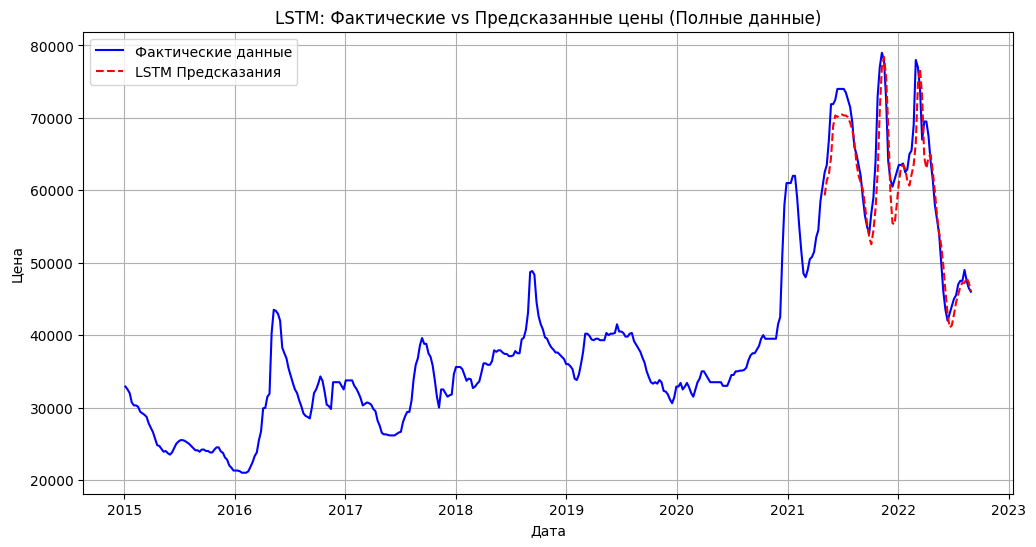

In [283]:
plt.figure(figsize=(12, 6))

# Фактические данные (все)
plt.plot(df.index, df["Цена на арматуру"], label="Фактические данные", color="blue")

# Предсказанные данные (только тестовая часть), смещаем на seq_length + train_size
plt.plot(test.index[seq_length:], lstm_pred, label="LSTM Предсказания", color="red", linestyle="dashed")

plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("LSTM: Фактические vs Предсказанные цены (Полные данные)")
plt.legend()
plt.grid()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

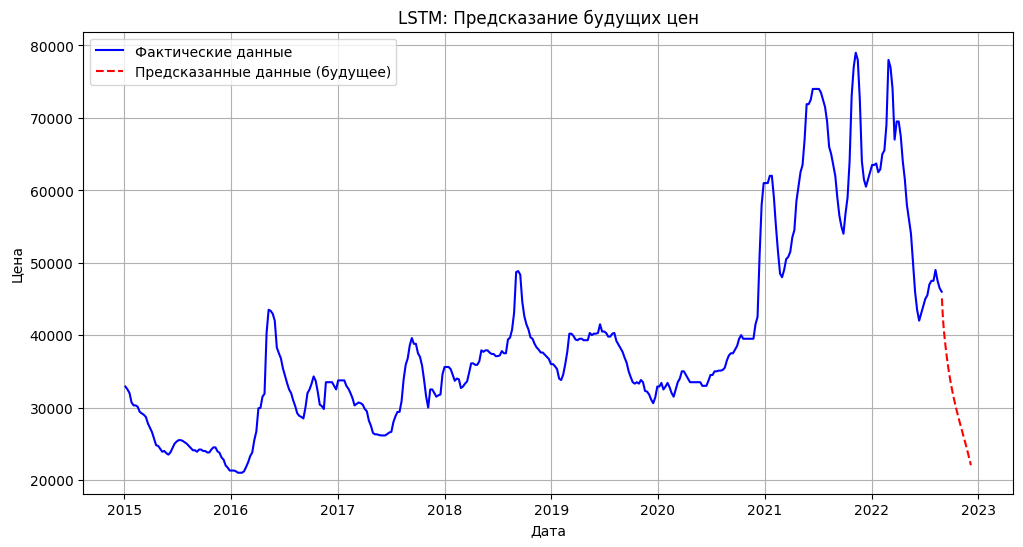

In [284]:
future_steps = 100  # Количество дней для предсказания вперёд

# Берём последние seq_length значений для предсказания
input_sequence = df["Цена_норм"].values[-seq_length:].reshape(1, seq_length, 1)

future_predictions = []

for _ in range(future_steps):
    pred = model.predict(input_sequence)  # Предсказание на 1 шаг вперёд
    future_predictions.append(pred[0, 0])  # Сохраняем предсказанное значение
    
    # Обновляем входную последовательность, сдвигаем окно на 1 шаг
    input_sequence = np.roll(input_sequence, -1)
    input_sequence[0, -1, 0] = pred[0, 0]

# Преобразуем предсказания обратно из нормализованных значений
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Создаём временной ряд для предсказанных значений
future_dates = pd.date_range(start=df.index[-1], periods=future_steps+1, freq="D")[1:]

# График предсказаний
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Цена на арматуру"], label="Фактические данные", color="blue")
plt.plot(future_dates, future_predictions, label="Предсказанные данные (будущее)", color="red", linestyle="dashed")

plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("LSTM: Предсказание будущих цен")
plt.legend()
plt.grid()
plt.show()


In [285]:
# Улучшенная модель LSTM
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.3),
    LSTM(100, return_sequences=True),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(50),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)


Epoch 1/100


c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0227
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0105
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0035
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0033
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0025
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027
Epoch 16/100
20/

In [286]:
df_new = pd.read_excel("test.xlsx")

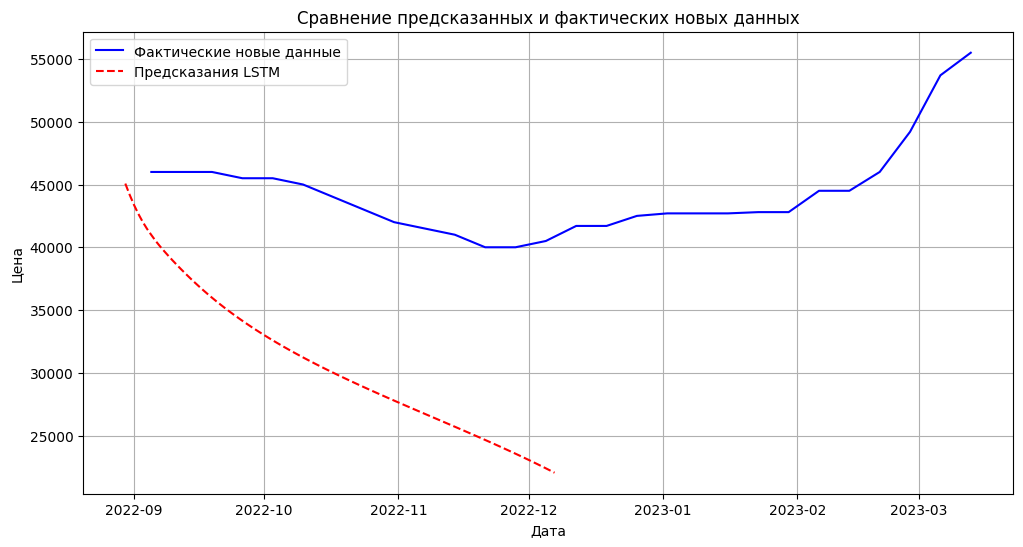

In [287]:
# ЗАГРУЗКА НОВЫХ ДАННЫХ
df_new["dt"] = pd.to_datetime(df_new["dt"])
df_new.set_index("dt", inplace=True)

# ВЫВОД ГРАФИКА НОВЫХ ДАННЫХ
plt.figure(figsize=(12, 6))
plt.plot(df_new.index, df_new["Цена на арматуру"], label="Фактические новые данные", color="blue")

# Если уже сделали предсказания вперёд, добавляем их на график
plt.plot(future_dates, future_predictions, label="Предсказания LSTM", color="red", linestyle="dashed")

plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Сравнение предсказанных и фактических новых данных")
plt.legend()
plt.grid()
plt.show()


Epoch 1/100


C:\Users\josha\AppData\Local\Temp\ipykernel_23520\3135777856.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Цена_норм"] = scaler.fit_transform(train[["Цена_неделя"]])
C:\Users\josha\AppData\Local\Temp\ipykernel_23520\3135777856.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Цена_норм"] = scaler.transform(test[["Цена_неделя"]])
c:\Users\josha\OneDrive\Documents\GitHub\3_intensiv_3\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`inpu

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0558
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140 
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025    
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032 
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 
Epoch 13/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034
Epoch 14/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 
Epoch 15/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020
Ep

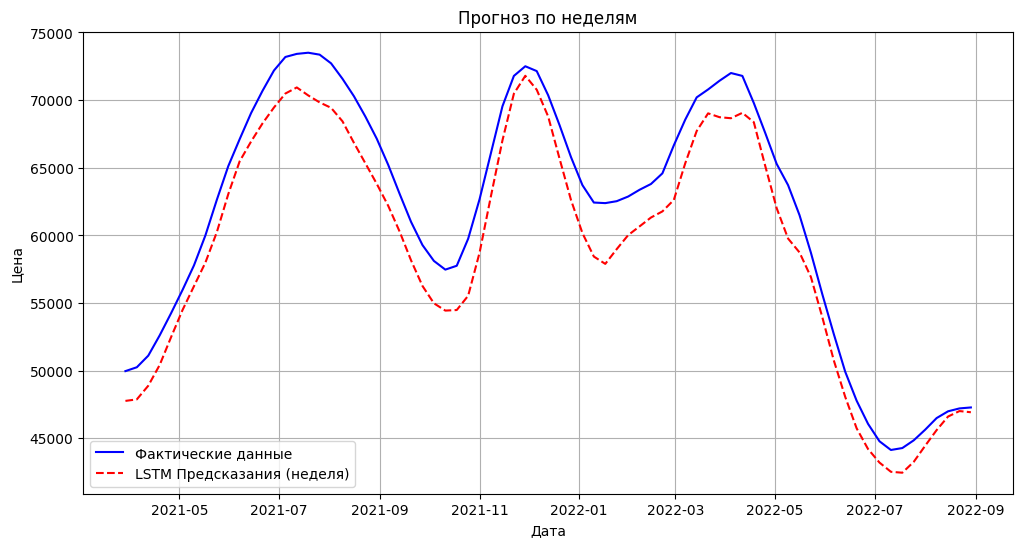

In [288]:
df["Цена_неделя"] = df["Цена на арматуру"].rolling(window=7).mean()
df.dropna(inplace=True)  # Убираем пустые значения

# Разделяем train/test
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Создаём последовательности по 4 недели (месяц назад → следующая неделя)
def create_weekly_sequences(data, seq_length=4):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return np.array(sequences), np.array(labels)

# Применяем к нормализованным данным
scaler = MinMaxScaler()
train["Цена_норм"] = scaler.fit_transform(train[["Цена_неделя"]])
test["Цена_норм"] = scaler.transform(test[["Цена_неделя"]])

X_train, y_train = create_weekly_sequences(train["Цена_норм"].values)
X_test, y_test = create_weekly_sequences(test["Цена_норм"].values)

# Добавляем размерности для LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(4, 1)),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

# Делаем прогноз
weekly_pred = model.predict(X_test)
weekly_pred = scaler.inverse_transform(weekly_pred)  # Возвращаем к нормальному масштабу

plt.figure(figsize=(12, 6))
plt.plot(test.index[4:], test["Цена_неделя"].iloc[4:], label="Фактические данные", color="blue")
plt.plot(test.index[4:], weekly_pred, label="LSTM Предсказания (неделя)", color="red", linestyle="dashed")
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Прогноз по неделям")
plt.legend()
plt.grid()
plt.show()
